Наша практика будет основана на соревновании [Kaggle: Predicting a Biological Response](https://www.kaggle.com/c/bioresponse) (Прогнозирование биологического ответа).

Необходимо предсказать биологический ответ молекул (столбец 'Activity') по их химическому составу (столбцы D1-D1776).

Данные представлены в формате CSV.  Каждая строка представляет молекулу. 

* Первый столбец Activity содержит экспериментальные данные, описывающие фактический биологический ответ [0, 1]; 
* Остальные столбцы D1-D1776 представляют собой молекулярные **дескрипторы** — это вычисляемые свойства, которые могут фиксировать некоторые характеристики молекулы, например размер, форму или состав элементов.

Предварительная обработка не требуется, данные уже закодированы и нормализованы.

В качестве метрики будем использовать **F1-score**.

Необходимо обучить две модели: **логистическую регрессию и случайный лес**. Далее нужно сделать подбор гиперпараметров с помощью базовых и продвинутых методов оптимизации. Важно использовать **все четыре метода** (GridSearchCV, RandomizedSearchCV, Hyperopt, Optuna) хотя бы по разу, максимальное количество итераций не должно превышать 50.

In [3]:
#импорт библиотек
import matplotlib
import matplotlib.pyplot as plt  # для визуализации
import numpy as np  # для матричных вычислений
import pandas as pd  # для анализа и предобработки данных
import seaborn as sns  # для визуализации
import sklearn
# from sklearn import tree #деревья решений
from sklearn import ensemble  # ансамбли
from sklearn import linear_model  # линейные модели
from sklearn import metrics  # метрики
# from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split  # сплитование выборки

# %matplotlib inline
# plt.style.use('seaborn')

In [4]:
print('matplotlib', matplotlib.__version__)
print('numpy', np.__version__)
print('pandas', pd.__version__)
print('seaborn', sns.__version__)
print('scikit-learn', sklearn.__version__)

numpy 1.22.4
pandas 1.4.4
matplotlib 3.7.1
seaborn 0.12.2
scikit-learn 1.2.2


### Знакомство с данными и их исследование

In [5]:
data = pd.read_csv(r'C:\Users\User\SkillFactory\data\_train_sem09__1_.zip')
# data = pd.read_csv('/content/drive/MyDrive/Skillfactory/data/_train_sem09__1_.zip')
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3751 entries, 0 to 3750
Columns: 1777 entries, Activity to D1776
dtypes: float64(942), int64(835)
memory usage: 50.9 MB


Проверяем наличие пропусков

In [7]:
data.isnull().sum().unique() # Пропусков нет.

array([0], dtype=int64)

In [8]:
data.describe()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
count,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,...,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000
mean,0.542255,0.076948,0.592436,0.068142,0.038990,0.212112,0.686653,0.274713,0.455133,0.749517,...,0.026926,0.014663,0.013863,0.021861,0.015196,0.016796,0.012263,0.011730,0.020261,0.011197
std,0.498278,0.079989,0.105860,0.078414,0.115885,0.102592,0.078702,0.090017,0.162731,0.071702,...,0.161889,0.120215,0.116938,0.146249,0.122348,0.128522,0.110074,0.107683,0.140911,0.105236
min,0.000000,0.000000,0.282128,0.000000,0.000000,0.002630,0.137873,0.006130,0.000000,0.275590,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.033300,0.517811,0.000000,0.000000,0.138118,0.625627,0.207374,0.378062,0.707339,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.066700,0.585989,0.050000,0.000000,0.190926,0.674037,0.277845,0.499942,0.738961,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.100000,0.668395,0.100000,0.000000,0.261726,0.740663,0.335816,0.569962,0.788177,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,0.964381,0.950000,1.000000,1.000000,0.994735,0.790831,0.989870,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Смотрим на сбалансированность классов:

<Axes: xlabel='Activity', ylabel='count'>

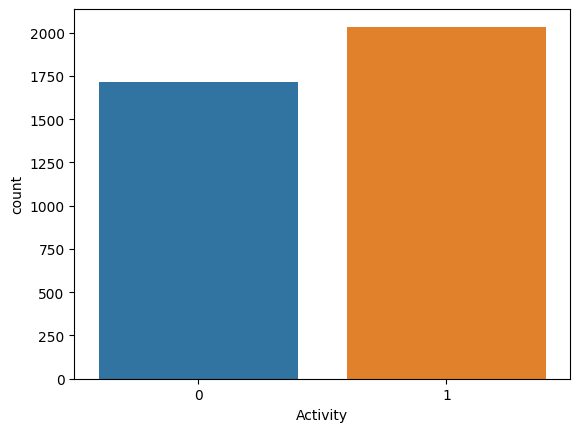

In [9]:
sns.countplot(data=data, x='Activity')

Создаем матрицу наблюдений $X$ и вектор ответов $y$

In [10]:
X = data.drop(['Activity'], axis=1)
y = data['Activity']

Разделяем выборку на тренировочную и тестовую в соотношении 80/20. Для сохранения соотношений целевого признака используем параметр stratify (стратифицированное разбиение).

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1, test_size=0.2)

### Оптимизация гиперпараметров модели

#### **Логистическая регрессия**

Зафиксируем только метрики, которые были получены без дополнительной настройки, т.е со значениями гиперпараметров, установленных по умолчанию:

In [12]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression()
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train, y_train)
print("accuracy на тестовом наборе: {:.2f}".format(log_reg.score(X_test, y_test)))
y_test_pred = log_reg.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.76
f1_score на тестовом наборе: 0.78


E:\ProgramData7\Anaconda3\envs\Find hyperparameters\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Случайный лес**

Проделаем аналогичное для RandomForestClassifier(). Сначала посчитаем модель с параметрами по умолчанию и оценим метрику:

In [13]:
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(random_state=42)

#Обучаем модель
rf.fit(X_train, y_train)
#Выводим значения метрики 
y_train_pred = rf.predict(X_train)
print('f1_score на тренировочном наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = rf.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тренировочном наборе: 1.00
f1_score на тестовом наборе: 0.81


### <center> **GridSearchCV**

**Для логистической регрессии**

In [14]:
from sklearn.model_selection import GridSearchCV

param_grid = {'penalty': ['l2', 'none'], #тип регурялизации
              'solver': ['lbfgs', 'saga'], #алгоритм оптимизации
              }
grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=42, #генератор случайных чисел
        max_iter=50 #количество итераций на сходимость
                                              ), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs=-1
                          )  
%time grid_search.fit(X_train, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search.score(X_test, y_test)))
y_test_pred = grid_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

CPU times: total: 7 s
Wall time: 57.4 s
accuracy на тестовом наборе: 0.76
f1_score на тестовом наборе: 0.78
Наилучшие значения гиперпараметров: {'penalty': 'l2', 'solver': 'saga'}


E:\ProgramData7\Anaconda3\envs\Find hyperparameters\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Значение метрики не изменилось, но это значит лишь, что мы не нашли комбинацию внешних параметров лучше, чем заданы по умолчанию. Это не удивительно и достаточно часто исходные гиперпараметры дают неплохой результат, но это не повод останавливаться.

**Попробуем расширить сетку гиперпараметров.**

In [15]:
param_grid = [
              {'penalty': ['l2', 'none'], # тип регуляризации
              'solver': ['lbfgs', 'sag'], # алгоритм оптимизации
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}, # уровень силы регурялизации
              
              {'penalty': ['l1', 'l2'],
              'solver': ['liblinear', 'saga'],
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}
]
grid_search_1 = GridSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=42, #генератор случайных чисел
        max_iter=50 #количество итераций на сходимость
                                              ), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs=-1
                            )  
%time grid_search_1.fit(X_train, y_train)
y_test_pred = grid_search_1.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_1.best_params_))

CPU times: total: 3.79 s
Wall time: 8min 42s
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}


E:\ProgramData7\Anaconda3\envs\Find hyperparameters\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Метрику удалось улучшить, а время потратили много, в 8 раз больше!**

Поиск по сетке не гарантирует, что мы найдем наилучшую комбинацию гиперпараметров, а все потому что сетка значений конечна и фактическое наилучшее значение может отсутствовать или оказаться между значений, заданными нами.

Ознакомиться с итоговой полученной моделью можно с помощью best_estimator_.

In [16]:
print("Наилучшая модель:\n{}".format(grid_search.best_estimator_))

Наилучшая модель:
LogisticRegression(max_iter=50, random_state=42, solver='saga')


In [17]:
print("Наилучшая модель:\n{}".format(grid_search_1.best_estimator_))

Наилучшая модель:
LogisticRegression(C=0.1, max_iter=50, random_state=42)


**Для случайного леса**

In [18]:
param_grid = {'n_estimators': list(range(80, 200, 30)),
              'min_samples_leaf': [5],
              'max_depth': list(np.linspace(20, 40, 5, dtype=int))
              }
            
grid_search_forest = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs=-1
                                  )  
%time grid_search_forest.fit(X_train, y_train) 
y_train_pred = grid_search_forest.predict(X_train)
# print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
# print("accuracy на тестовом наборе: {:.2f}".format(grid_search_forest.score(X_test, y_test)))
y_test_pred = grid_search_forest.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_forest.best_params_))

CPU times: total: 5.73 s
Wall time: 3min 40s
f1_score на тестовом наборе: 0.82
Наилучшие значения гиперпараметров: {'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 140}


### <center> **RandomizedSearchCV**

**Для логистической регресии**

In [19]:
from sklearn.model_selection import RandomizedSearchCV

#np.linspace(start(от), stop(до), num=50(количество),dtype- тип данных)
param_grid = {'penalty': ['l2', 'none'] ,
              'solver': ['lbfgs', 'sag'],
               'C': list(np.linspace(0.01, 1, 10, dtype=float))
             }
            
random_search = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=42, #генератор случайных чисел
        max_iter=50 #количество итераций на сходимость
                                              ),
    param_distributions=param_grid,
    cv=5, 
    n_iter=10, 
    n_jobs=-1
                                    )  
%time random_search.fit(X_train, y_train) 
# print("accuracy на тестовом наборе: {:.2f}".format(random_search.score(X_test, y_test)))
y_test_pred = random_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))

CPU times: total: 5.37 s
Wall time: 1min 30s
f1_score на тестовом наборе: 0.78
Наилучшие значения гиперпараметров: {'solver': 'sag', 'penalty': 'l2', 'C': 0.23}


E:\ProgramData7\Anaconda3\envs\Find hyperparameters\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


**Для случайного леса**

In [20]:
param_grid = {'n_estimators': list(range(80, 200, 30)),
              'min_samples_leaf': [5],
              'max_depth': list(np.linspace(20, 40, 10, dtype=int))
              }
            
random_search_forest = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_distributions=param_grid, 
    cv=5,
    n_iter=10, 
    n_jobs=-1
                                          )  
%time random_search_forest.fit(X_train, y_train) 
y_train_pred = random_search_forest.predict(X_train)
# print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
# print("accuracy на тестовом наборе: {:.2f}".format(random_search_forest.score(X_test, y_test)))
y_test_pred = random_search_forest.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_forest.best_params_))

CPU times: total: 3.4 s
Wall time: 1min 47s
f1_score на тестовом наборе: 0.83
Наилучшие значения гиперпараметров: {'n_estimators': 80, 'min_samples_leaf': 5, 'max_depth': 22}


### <center> Hyperopt

In [21]:
#делаем импорт и выведем версию библиотеки
# from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials
# fmin - основная функция, она будет минимизировать наш функционал
# tpe - алгоритм оптимизации
# hp - включает набор методов для объявления пространства поиска гиперпараметров
# trails - используется для логирования результатов

print("Версия Hyperopt: {}".format(hyperopt.__version__))

Версия Hyperopt : 0.2.7


**Для случайного леса**

In [22]:
# зададим пространство поиска гиперпараметров
space={'n_estimators': hp.quniform('n_estimators', 100, 200, 1),
       'max_depth' : hp.quniform('max_depth', 15, 26, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 10, 1)
      }

In [23]:
# зафиксируем random_state
random_state = 42
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))
    
    # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    # score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [24]:
%%time
# начинаем подбор гиперпараметров

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state) # фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

100%|████████| 20/20 [01:49<00:00,  5.45s/trial, best loss: -0.988653787181846]
Наилучшие значения гиперпараметров {'max_depth': 18.0, 'min_samples_leaf': 2.0, 'n_estimators': 103.0}
CPU times: total: 1min 43s
Wall time: 1min 49s


In [25]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
                                        )
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
# print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
# print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.82


**Для логистической регрессии**

In [26]:
from sklearn.model_selection import cross_val_score
RANDOM_STATE = 42
# зададим пространство поиска гиперпараметров
# Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']
space = hp.choice('parameter_combinations', 
                  [{'solver': 'saga',
                    'penalty': hp.choice('penalty', ['l1', 'l2']),
                    'C': hp.uniform('C_saga', 0.01, 1)
                    },
                   {'solver': 'lbfgs',
                    'penalty': 'l2',
                    'C': hp.uniform('C_lbfgs', 0.01, 1)
                    }
                   ]
                 )

# Целевая функция
def obj_func(params, cv=5, X=X_train, y=y_train, random_state=RANDOM_STATE):
    params = {'solver': params['solver'], 
              'penalty': params['penalty'], 
              'C': params['C']
              }
      
    model = linear_model.LogisticRegression(**params, class_weight='balanced', 
        random_state=random_state, max_iter=50
                                            )
      
    # Обучаем модель с помощью кросс-валидации
    score = cross_val_score(model, X, y, cv=cv, scoring='f1', n_jobs=-1).mean()

    return -score 


trials = Trials()
best=fmin(obj_func, 
          space=space, 
          algo=tpe.suggest, 
          max_evals=20, 
          trials=trials, 
          #rstate=np.random.RandomState(random_state)
          rstate=np.random.default_rng(RANDOM_STATE)
         )

100%|███████| 20/20 [04:25<00:00, 13.26s/trial, best loss: -0.7787274418174028]


In [27]:
print(f'Наилучшие значения гиперпараметров: {best}')

Наилучшие значения гиперпараметров: {'C_lbfgs': 0.2200949458234019, 'parameter_combinations': 1}


## <center> Optuna

In [28]:
# !pip install optuna

In [29]:
import optuna

E:\ProgramData7\Anaconda3\envs\Find hyperparameters\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [30]:
optuna.__version__

'3.1.0'

**Для логистической регрессии**

In [31]:
# Целевая функция
def obj_func(trial):
    # пространство гиперпараметров
    solver = trial.suggest_categorical('solver', ['saga', 'lbfgs'])
    if solver == 'saga':
        penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    else:
        penalty = 'l2'
    C = trial.suggest_uniform('C', 0.01, 1)
    
    model = linear_model.LogisticRegression(
        solver=solver,
        penalty=penalty,
        C=C,
        class_weight='balanced', 
        random_state=RANDOM_STATE, 
        max_iter=50
                                            )    
    
    # Обучаем модель с помощью кросс-валидации    
    score = cross_val_score(
        model, X_train, y_train, cv=5, scoring='f1', n_jobs=-1).mean()
    
    return score

# Поиск оптимальных гиперпараметров
sampler = optuna.samplers.TPESampler(seed=RANDOM_STATE)
study_lr = optuna.create_study(
    sampler=sampler, study_name='LogisticRegression', direction='maximize')
study_lr.optimize(obj_func, n_trials=20)

# Модель с лучшими параметрами
optuna_lr = linear_model.LogisticRegression(
    **study_lr.best_params, class_weight='balanced', n_jobs=-1,
    random_state=RANDOM_STATE, max_iter=50
                                            )
optuna_lr.fit(X_train, y_train)
y_train_pred = optuna_lr.predict(X_train)
y_test_pred = optuna_lr.predict(X_test)

[I 2023-03-31 20:40:06,484] A new study created in memory with name: LogisticRegression
C:\Users\User\AppData\Local\Temp\ipykernel_6528\2246984164.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_uniform('C', 0.01, 1)
[I 2023-03-31 20:40:12,642] Trial 0 finished with value: 0.765298050264929 and parameters: {'solver': 'lbfgs', 'C': 0.7346740023932911}. Best is trial 0 with value: 0.765298050264929.
C:\Users\User\AppData\Local\Temp\ipykernel_6528\2246984164.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_uniform('C', 0.01, 1)
[I 2023-03-31 20:40:40,515] Trial 1 finished with value: 0.7764867705363445 and para

[I 2023-03-31 20:44:09,412] Trial 15 finished with value: 0.777227427742206 and parameters: {'solver': 'saga', 'penalty': 'l2', 'C': 0.5957667995707591}. Best is trial 10 with value: 0.7776116597991605.
C:\Users\User\AppData\Local\Temp\ipykernel_6528\2246984164.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_uniform('C', 0.01, 1)
[I 2023-03-31 20:44:37,237] Trial 16 finished with value: 0.7747442511441909 and parameters: {'solver': 'saga', 'penalty': 'l1', 'C': 0.8347616888265146}. Best is trial 10 with value: 0.7776116597991605.
C:\Users\User\AppData\Local\Temp\ipykernel_6528\2246984164.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` 

In [32]:
print(f'Наилучшие значения гиперпараметров: {study_lr.best_params}')
print(f'F1 на кросс-валидации: {study_lr.best_value}')
print(f'F1 на тренировочной выборке: {metrics.f1_score(y_train, y_train_pred)}')
print(f'F1 на тестовой выборке: {metrics.f1_score(y_test, y_test_pred)}')

Наилучшие значения гиперпараметров: {'solver': 'saga', 'penalty': 'l2', 'C': 0.7013203423085284}
F1 на кросс-валидации: 0.7779846433860036
F1 на тренировочной выборке: 0.8558979147214442
F1 на тестовой выборке: 0.7769607843137254


**Для случайного леса**

In [33]:
def optuna_rf(trial):
    # задаем пространства поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

    # создаем модель
    model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                            max_depth=max_depth,
                                            min_samples_leaf=min_samples_leaf,
                                            random_state=random_state)
    # обучаем модель
    model.fit(X_train, y_train)
    score = metrics.f1_score(y_train, model.predict(X_train))

    return score

In [34]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2023-03-31 20:45:40,148] A new study created in memory with name: RandomForestClassifier
[I 2023-03-31 20:45:46,390] Trial 0 finished with value: 0.9020445529447665 and parameters: {'n_estimators': 184, 'max_depth': 27, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.9020445529447665.
[I 2023-03-31 20:45:50,374] Trial 1 finished with value: 0.9014084507042253 and parameters: {'n_estimators': 127, 'max_depth': 20, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.9020445529447665.
[I 2023-03-31 20:45:54,555] Trial 2 finished with value: 0.9353355807539074 and parameters: {'n_estimators': 113, 'max_depth': 19, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.9353355807539074.
[I 2023-03-31 20:46:01,506] Trial 3 finished with value: 0.9776416539050536 and parameters: {'n_estimators': 163, 'max_depth': 30, 'min_samples_leaf': 3}. Best is trial 3 with value: 0.9776416539050536.
[I 2023-03-31 20:46:06,642] Trial 4 finished with value: 0.9578497251069028 and parameters: {'

CPU times: total: 1min 42s
Wall time: 1min 45s


In [35]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 145, 'max_depth': 22, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.99


In [36]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params, random_state=random_state)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.80
f1_score на тестовом наборе: 0.82


In [37]:
%%time
# можем прододжить подбор, указав n_trials(любое число, которое добавится к предыдущим итерациям) 
study.optimize(optuna_rf, n_trials=10)

[I 2023-03-31 20:47:38,786] Trial 20 finished with value: 0.9148805878750765 and parameters: {'n_estimators': 172, 'max_depth': 15, 'min_samples_leaf': 8}. Best is trial 17 with value: 0.991421568627451.
[I 2023-03-31 20:47:44,822] Trial 21 finished with value: 0.9911179173047474 and parameters: {'n_estimators': 120, 'max_depth': 28, 'min_samples_leaf': 2}. Best is trial 17 with value: 0.991421568627451.
[I 2023-03-31 20:47:50,426] Trial 22 finished with value: 0.9908088235294118 and parameters: {'n_estimators': 106, 'max_depth': 21, 'min_samples_leaf': 2}. Best is trial 17 with value: 0.991421568627451.
[I 2023-03-31 20:48:00,234] Trial 23 finished with value: 0.9761467889908259 and parameters: {'n_estimators': 124, 'max_depth': 28, 'min_samples_leaf': 3}. Best is trial 17 with value: 0.991421568627451.
[I 2023-03-31 20:48:04,962] Trial 24 finished with value: 0.9338640538885488 and parameters: {'n_estimators': 109, 'max_depth': 10, 'min_samples_leaf': 2}. Best is trial 17 with value:

CPU times: total: 56.6 s
Wall time: 1min 11s


In [38]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 145, 'max_depth': 22, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.99


In [39]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params, random_state=random_state)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.80
f1_score на тестовом наборе: 0.82


Добавление 10 итераций никакого улучшения не дало.